# K Arm Bandit PyGame

![title](k_arm_bandit_pic.png)

# Load Packages

In [1]:
import pygame
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pygame 2.6.0 (SDL 2.28.4, Python 3.9.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Class Object

In [2]:
class KarmEnv():
    
    def __init__(self, probs):
        
        # Get number of arms
        self.probs = probs
        self.grid_rows = len(probs)
        
    def reset(self):
        
        None
        
    def step(self):
        
        None
        
    def init_render(self):
        
        # Colors
        self.black = (0, 0, 0)
        self.white = (255, 255, 255)
        self.red = (255, 0, 0)
        self.green = (0, 255, 0)
        self.blue = (0, 0, 255)

        # Rectangle information
        self.box_width = 40
        self.box_height = 40
        self.box_margin = 10
        self.box_width_max = 400

        # Window information
        self.left_margin = 250
        self.right_margin = 100
        self.bottom_margin = 50
        self.top_margin = 50

        # Initialize window
        pygame.init()
        self.window_size = [self.left_margin + self.box_margin + self.box_width_max + self.right_margin, self.top_margin + (self.box_margin + self.box_height) * self.grid_rows + self.bottom_margin]
        self.screen = pygame.display.set_mode(self.window_size)
        pygame.display.set_caption("K-Arm Bandit")
        self.clock = pygame.time.Clock()
        
    def render(self, ep_num, q_vals):
        
        self.screen.fill(self.black)
        for row in range(self.grid_rows):
        
            # Draw rectangles
            pygame.draw.rect(self.screen, self.white,
                             [self.box_margin + self.left_margin, (self.box_margin + self.box_height) * row + self.box_margin,
                              self.box_width_max*q_vals[row], self.box_height])
        
            # Specify arm number and q-values
            self.text_arm = pygame.font.Font(None, 40).render('Arm # '+str(row+1)+' = '+str(q_vals[row]), False, 'white')
            self.screen.blit(self.text_arm,((self.box_margin, (self.box_margin + self.box_height) * row + self.box_margin)))
    
        # Draw graph
        pygame.draw.line(self.screen, self.white, (self.left_margin,self.box_margin),(self.left_margin, (self.box_margin + self.box_height)*self.grid_rows + self.box_margin), width=5) # Vertical
        pygame.draw.line(self.screen, self.white,(self.left_margin, (self.box_margin + self.box_height)*self.grid_rows + self.box_margin), (self.left_margin + self.box_width_max + self.box_margin,(self.box_margin + self.box_height)*self.grid_rows + self.box_margin), width=5) # Horizontal
        self.text_zero = pygame.font.Font(None, 40).render('0', False, 'white')
        self.screen.blit(self.text_zero,(self.left_margin,(self.box_margin + self.box_height)*self.grid_rows + self.box_margin+10))
        self.text_one = pygame.font.Font(None, 40).render('1', False, 'white')
        self.screen.blit(self.text_one,((self.left_margin + self.box_width_max + self.box_margin -10,(self.box_margin + self.box_height)*self.grid_rows + self.box_margin+10)))
    
        # Draw episode number
        self.text_episode = pygame.font.Font(None, 60).render('Episode # '+str(ep_num), False, 'white')
        self.screen.blit(self.text_episode,((self.left_margin+self.box_width_max/5, (self.box_height+self.box_margin) * self.grid_rows + 50)))
    
        # Clock and Update
        self.clock.tick(500)
        pygame.display.update()

# Greedy Action Function

In [3]:
def greedy(q_vals, epsilon):
    
    # Randomly select action with probability epsilon
    if np.random.uniform() < epsilon:
        g_action = np.random.choice(actions)
        
    # Select the best action for the given state with probability 1-epsilon
    else:
        q_vals_max = np.where(q_vals==q_vals.max())[0]
        g_action = np.random.choice(q_vals_max)
    
    return g_action

# Bandit

In [4]:
# Set seed
np.random.seed(802)

# Probability for each bandit arm
probs = [0.10, 0.20, 0.25, 0.30, 0.45, 0.50, 0.55, 0.70, 0.80, 0.85]

# Initialize K-arm class
env = KarmEnv(probs)

# Number of bandit arms
actions = range(len(probs))

# Exploration rate
epsilon = 0.10

# Number of bandit episodes
episodes = 4000

In [5]:
# Number of times each action is taken
n_table = np.zeros(len(probs))

# Expected reward for each action
q_table = np.zeros(len(probs))

# The reward for each episode
reward = []

# The action taken each episode 
each_action = []
    
# Binary matrix of actions taken for each episode
action_mat = np.zeros([episodes, len(probs)])

# Initialize rendering
env.init_render()

# Play the Bandit with RL
for i in range(episodes):
    
    # PyGame
    for event in pygame.event.get(): 
        if event.type == pygame.QUIT: 
            episode_end = True
    
    # Find which action to take - Exploration vs Exploitation
    new_action = greedy(q_table, epsilon)
    
    # Save the action selection for each episode
    each_action.append(new_action)
        
    # Save the action for each arm across episodes in a binary matrix
    action_mat[i, new_action] += 1
    
    # Count number of times each action is selected
    n_table[new_action] += 1
    
    # Save the reward recieved for each epsiode
    reward.append( np.random.binomial(n=1, p=probs[new_action], size=1)[0] )
    
    # Update the expected reward for each action 
    q_table[new_action] = q_table[new_action] + ( (1/n_table[new_action]) * ( reward[-1] - q_table[new_action] ) )
    
    # Render
    env.render(i+1, q_table.round(2))
    
    # Pause at last episode
    if i+1 == episodes:
        time.sleep(3)
    
# Close Window
pygame.quit()

# View Results

In [6]:
print("The average reward recieved is", sum(reward)/len(reward), "for", episodes, "episodes.")

The average reward recieved is 0.79325 for 4000 episodes.


In [7]:
pd.DataFrame({"Bandit Arm":range(len(probs)), "Number of Actions":n_table, \
              "True Probability":probs, "Expected Reward":q_table.round(2)})

,Bandit Arm,Number of Actions,True Probability,Expected Reward
0,0,40.0,0.10,0.10
1,1,32.0,0.20,0.06
2,2,45.0,0.25,0.22
3,3,32.0,0.30,0.22
4,4,42.0,0.45,0.40
5,5,47.0,0.50,0.57
6,6,61.0,0.55,0.46
7,7,39.0,0.70,0.54
8,8,1345.0,0.80,0.80
9,9,2317.0,0.85,0.85


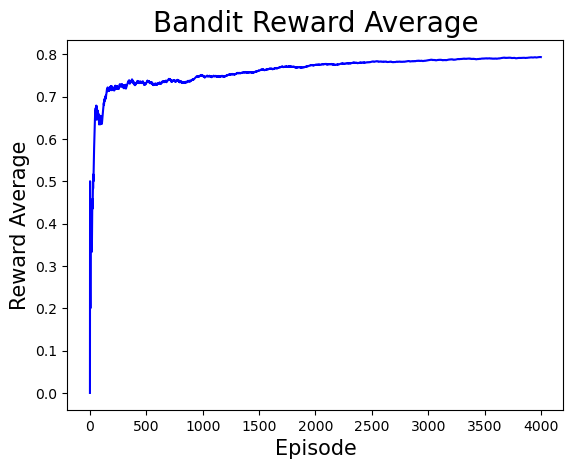

In [8]:
reward_ave = np.cumsum(reward) / (np.array(range(episodes))+1)
plt.plot(reward_ave, color="blue")
plt.title("Bandit Reward Average", fontsize=20)
plt.xlabel("Episode", fontsize=15)
plt.ylabel("Reward Average", fontsize=15)
plt.show()

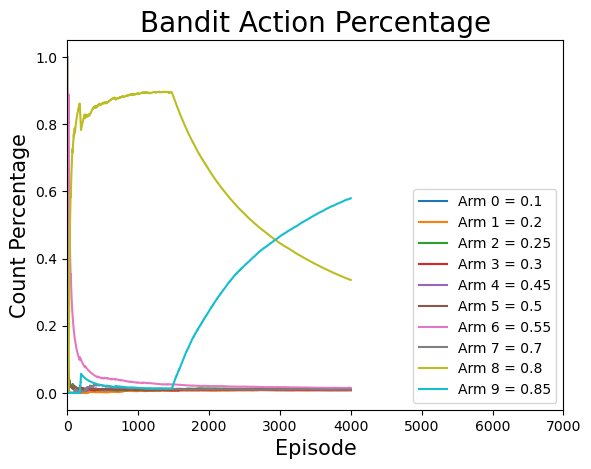

In [9]:
for i in range(len(probs)):
    
    action_counts = action_mat[:,i]
    count_perc = np.cumsum(action_counts) / (np.array(range(episodes))+1)
    plt.plot(count_perc, label="Arm "+str(i)+" = "+str(probs[i]))

plt.title("Bandit Action Percentage", fontsize=20)
plt.xlabel("Episode", fontsize=15)
plt.ylabel("Count Percentage", fontsize=15)
plt.xlim(0,episodes+3000)
plt.legend(loc="lower right")
plt.show()